# Práctica 7: Entrenamiento de Redes Neuronales

Universidad Iberoamericana Ciudad de México, Primavera 2024

Creado por: Luis Norberto Zúñiga Morales, inspirado en el libro *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition*.

**Objetivos**:
- Introducir la API de Keras a los estudiantes para la implementación de redes neuronales con Tensorflow.
- Implementar ideas básicas de una red neuronal mediante un ejemplo práctico de clasificación usando el dataset MNIST.
- Introducir métricas de evaluación, funciones de activación y funciones de pérdida.



---



Entrenar redes neuronales (profundas) puede llegar a ser complejo ya que existen ciertos problemas durante su entrenamiento. Algunos de estos incluyen:

- El problema de desvanecimiento de gradiente.
- Problemas con el tamaño del conjunto de datos.
- Entrenamiento lento.
- Sobreajuste dado el gran número de parámetros que puede llegar a tener la arquitectura de la red.

In [1]:
import keras
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Desvanecimiento de gradiente

En clase vimos que la función de activación sigmoide es una causante del problema de desvanecimiento de gradiente, en particular, las funciones saturantes. Cuando las entradas de la red se vuelven grandes (positivos o negativos), la función se satura en 0 o 1, y su derivada se vuelve muy cercana a 0. Al realizar el paso de retropropagación, el gradiente es muy pequeño y no existe actualización de los pesos conforme se alejan de la capa de salida.

In [6]:
def logit(z):
  return 1 / (1 + np.exp(-z))

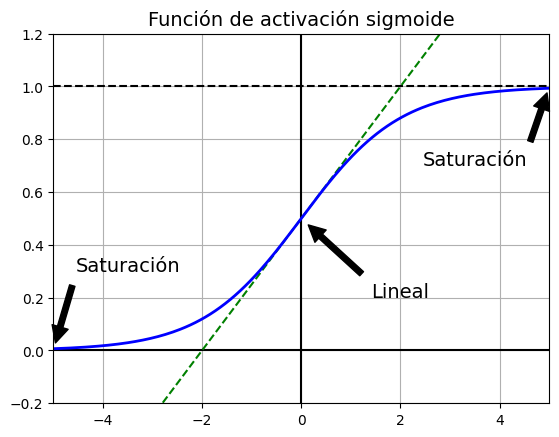

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturación', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturación', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Lineal', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Función de activación sigmoide", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Inicialización de Glorot y He

Glorot y Bengio proponen la siguiente forma para inicializar los pesos de una red neuronal:

$$N\left(0, \frac{1}{fan_{avg}}\right)$$

donde

$$fan_{avg} = \frac{fan_{in} + fan_{out}}{2}$$

o bien, una distribución uniforme entre $-r$ y $r$ donde

$$r = \sqrt{\frac{3}{fan_{avg}}}$$

La idea es que la señal no se muera o explote al atravesar la red, por lo que los autores proponen que la varianza de las salidas de cada capa debe ser igual a la varianza de las entradas, y los gradientes deben tener igual varianza antes y después de propagarse en la red. Esto depende de la cantidad de neuronas de entrada ($fan_{in}$) y salida ($fan_{out}$) de cada capa.

En automático, Keras utiliza la inicialización de Glorot con una distribución uniforme, pero puede modificarse con el parámetro `kernel_initializer` al momento de crear una capa. Entre las posibles inicializaciones se encuentran:

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [2]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

Si queremos modificar la inicialización de He con la distribución uniforme pero con $fan_{avg}$ en lugar de $fan_{in}$, podemos usar el inicializador `VarianceSaling` de la siguiente manera:

In [3]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### Funciones de activación no saturantes

En el mismo artículo de Glorot y Bengio se indica que otro factor que contribuye al desvanecimiento de gradiente es la selección de la función de activación. Hasta ese momento, la función más usada era la sigmoide, pero después se propusieron otras que se comportan mejor con redes neuronales profundas, en particular la función de activación ReLU, principalmente por que no se satura con valores positivos.

Sin embargo, la ReLU no es perfecta, ya que sufre de un problema llamado *muerte de ReLU*: durante el entrenamiento, algunas neuronas mueren, o que las neuronas no saquen una salida distinta a cero. Es posible que una gran parte de una red neuronal se encuentre muerta, especialmente si la razón de aprendizaje es grande. Esto surge si los pesos se ajustan de tal manera que la salida de la sumatoria sea negativo, lo que ocasiona que la ReLU lo vuelva cero, y el gradiente descendiente no afecta los pesos por que el gradiente de la ReLU es cero en ese caso.

Para resolver este problema, se han propuesta diversas variantes de la ReLU. Primero tenemos la Leaky ReLU, que se define como:

$$\text{Leaky ReLU}_\alpha (z) = \max(\alpha z, z)$$

donde $\alpha$ es el parámetro de fuga, el cual suele ser 0.01. Esta pequeña fuga evitar la muerte de neuronas.

In [4]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha*z, z)

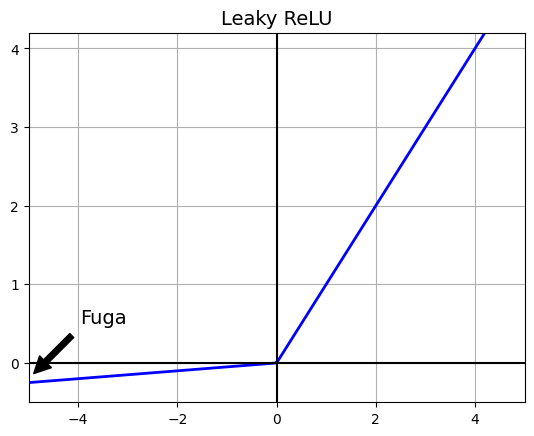

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Fuga', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

Para usar la Leaky ReLU:

In [9]:
keras.layers.Dense(10, activation='LeakyReLU')

Después tenemos la exponential linear unit (ELU), propuesta por Djork-Arné Clevert et al., que se define como:

$$\text{ELU}_{\alpha}(z) = \left\{ \begin{array}{lcc}
             \alpha(\exp{(z)}-1) &   si  & z < 0 \\
             \\z &  si & z \geq 0 \\
             \end{array}
   \right.$$

In [10]:
def elu(z, alpha=1):
  return np.where(z < 0, alpha * (np.exp(z) - 1), z)

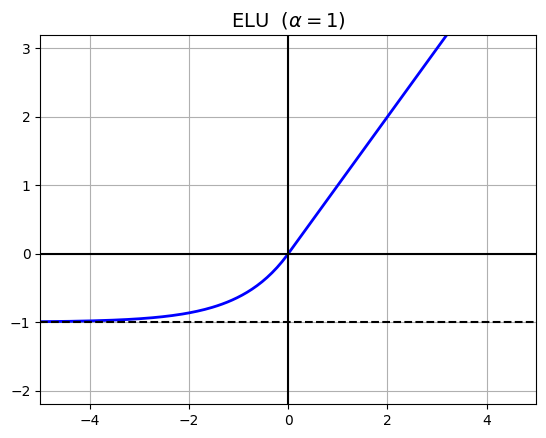

In [11]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU  ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

Esta función de activación tiene ciertas ventajas:
- Puede manejar valores negativos cuando $z<0$.
- Su gradiente para $z<0$ es distinto de cero, lo cual evita neuronas muertas.
- Si $\alpha = 1$, es suave en todos los puntos, incluido cerca de cero, lo cual acelera el gradiente descendiente.

Sin embargo, el gradiente suele ser un poco más tardado de calcular, a comparación de las funciones de activación anteriores.

Para usar la ELU:

In [12]:
keras.layers.Dense(10, activation="elu")

En 2017, Günter Klambauer et al. introdujeron la Scaled ELU (SELU): una variante escalada de la ELU. En el artículo demuestran que si utilizan capas densas y SELU, la red se auto normaliza, es decir, la salida de cada capa tiende a preservar una media de 0 y desviación estándar de 1, lo cual resuelve el problema del gradiente descendiente. En consecuencia, la SELU suele superar a las otras funciones de activación.

$$\text{SELU}_{\alpha,s}(z) = \left\{ \begin{array}{lcc}
             sz &   si  & z > 0 \\
             \\sa(e^x-1) &  si & z \leq 0 \\
             \end{array}
   \right.$$

donde $s = 1.05070098$ y $\alpha = 1.67326324$.

Algunos detalles:

- Las características (entradas de la red) deben tener media 0 y desviación estándar 1.
- Cada capa oculta debe ser inicializada con el método de LeCun.
- Solo funciona con modelos de redes secuenciales.

In [13]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [14]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale * elu(z, alpha)

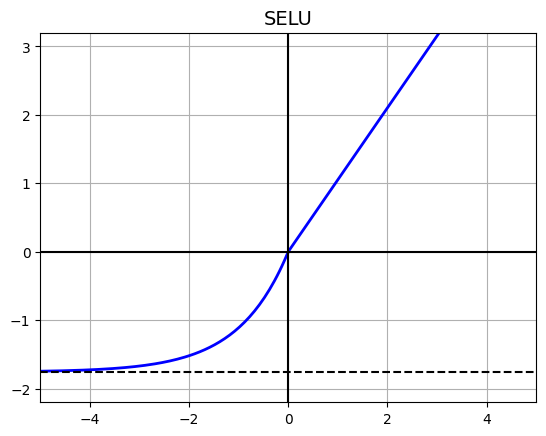

In [15]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Para usar la SELU:

In [16]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

Veamos la SELU en acción:

In [17]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
  W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
  Z = selu(np.dot(Z, W))
  means = np.mean(Z, axis=0).mean()
  stds = np.std(Z, axis=0).mean()
  if layer % 100 == 0:
    print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Algunas funciones de activación disponibles en Keras:

In [18]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Vamos a entrenar una red con el dataset de Fashion MNIST:

In [19]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [21]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.2654 - accuracy: 0.6083 - val_loss: 0.8696 - val_accuracy: 0.7204
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7849 - accuracy: 0.7445 - val_loss: 0.7037 - val_accuracy: 0.7710
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6730 - accuracy: 0.7821 - val_loss: 0.6366 - val_accuracy: 0.7972
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6139 - accuracy: 0.8007 - val_loss: 0.5827 - val_accuracy: 0.8106
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5762 - accuracy: 0.8108 - val_loss: 0.5520 - val_accuracy: 0.8208
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5494 - accuracy: 0.8168 - val_loss: 0.5291 - val_accuracy: 0.8280
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5295 - accuracy: 0.8229 - val_loss: 0.5108 - val_accuracy:

Otras técnicas para evitar el problema de desvanecimiento de gradiente descendiente incluyen Batch Normalization y Gradient Clipping.

## Learning Rate Scheduling

Cuando estudiamos gradiente descendiente mencionamos que la razón de aprendizaje $\eta$ controla la actualización del parámetro a optimizar. Un valor muy grande ocasiona grandes saltos, inclusive ocasionando que no converga el algoritmo. Por otro lado, un valor muy pequeño hace que el algoritmo tarde en converger. En pocas palabras, es una parámetro que debemos ajustar.

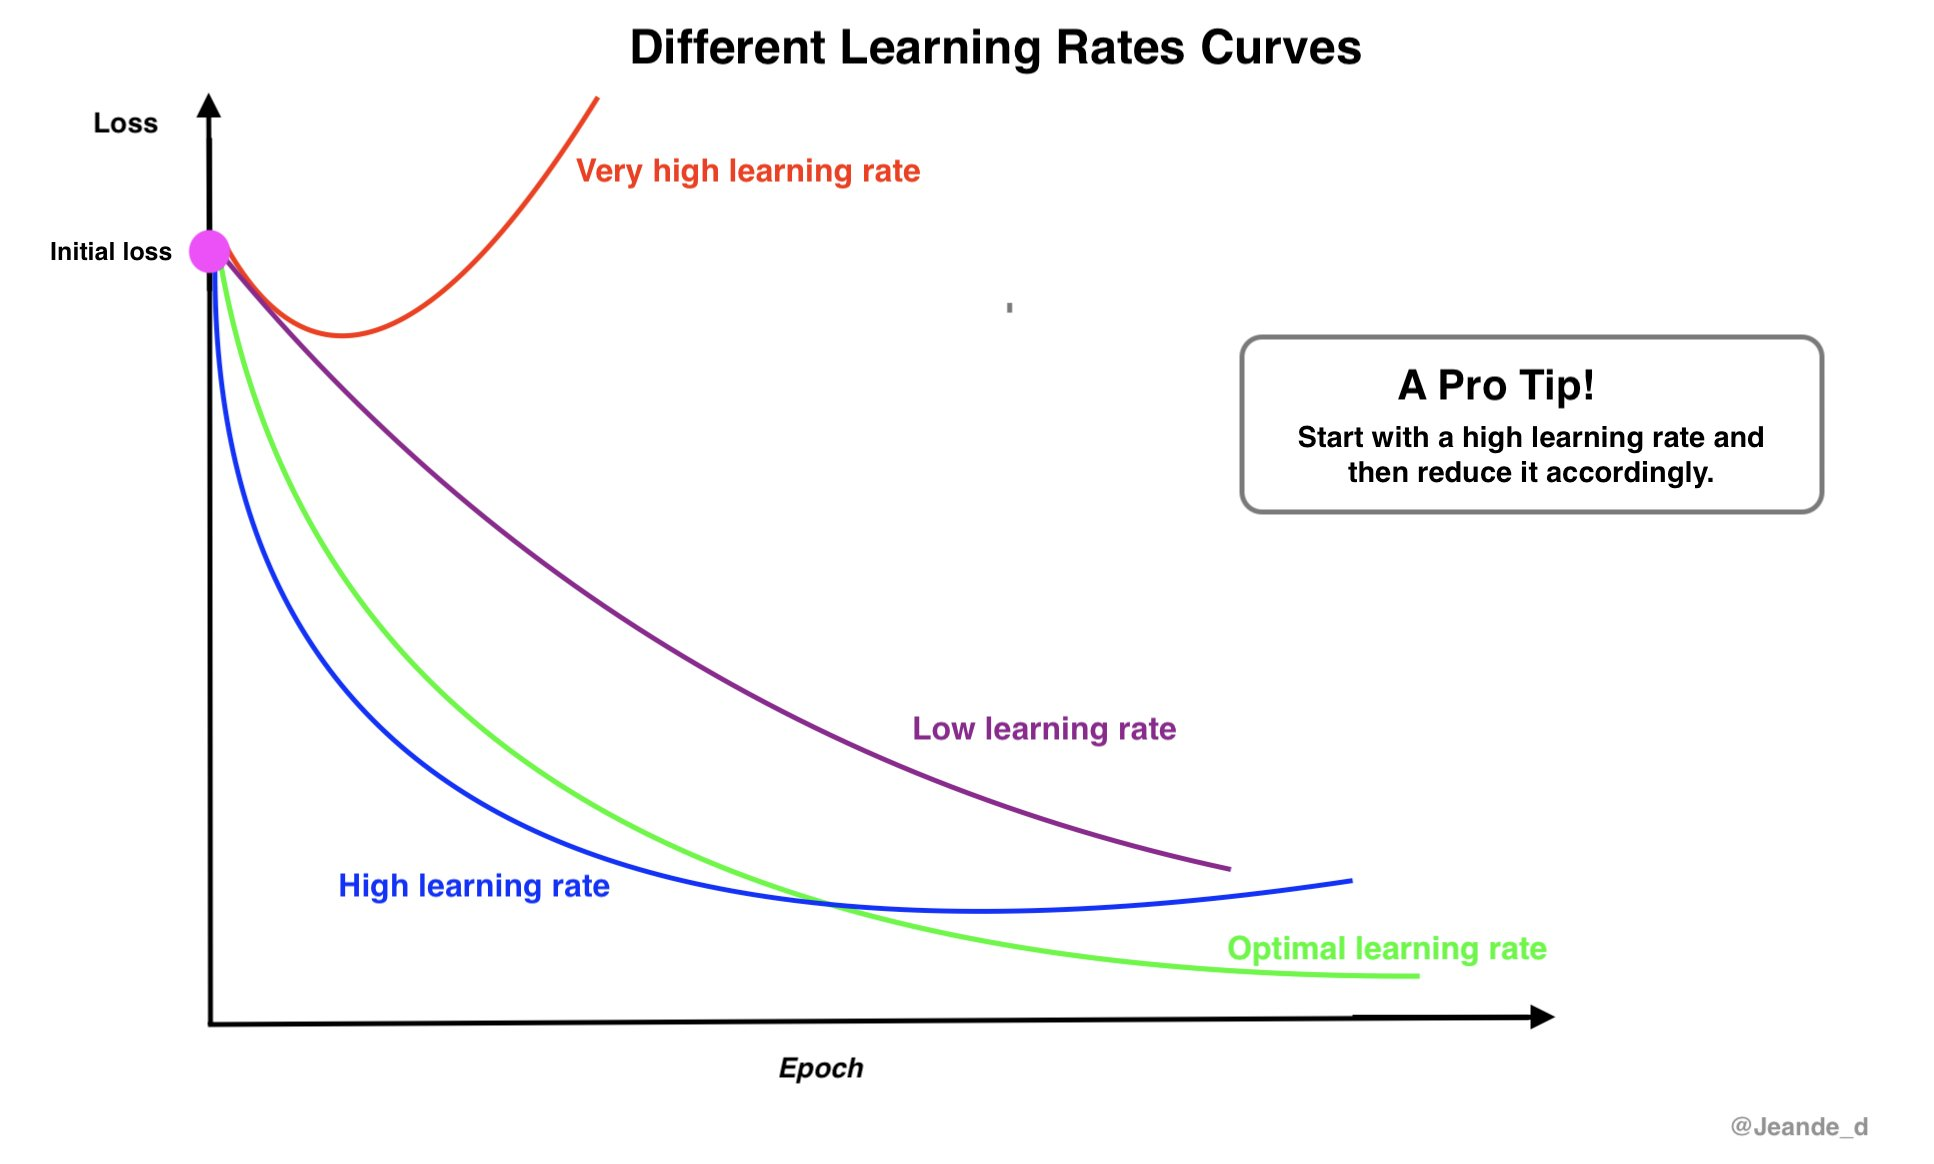

Fuente: [@Jeande_d](https://twitter.com/Jeande_d/status/1459222900066586625)

Una primera idea para aliviar este problema es entrenar el modelo unas cuantas iteraciones incrementando la razón de aprendizaje exponencialmente, desde un valor muy pequeño, hasta uno muy grande. Después, se grafica y se analiza la curva de aprendizaje, y se elige aquella con un valor ligeramente menor a la curva que empieza a subir de nuevo para entrenar la versión final de la red neuronal.

Sin embargo, existe una mejor opción dinámica: en lugar de usar un valor constante, se empieza con un valor grande para acelerar el proceso de convergencia, para después disminuir este valor poco a poco durante el entrenamiento. Existen diversas técnicas para implementar la idea anterior.

En un artículo del 2013, Andrew Senior et al. encontraron que los mejores métodos son *performance scheduling* y *exponential scheduling*, favoreciendo este último.

### Exponential Scheduling

La idea del *exponential scheduling* es que la razón de aprendizaje se define como

$$\eta(t) = \eta_o 0.1^{t/s}$$

Cada $s$ pasos, la razón de aprendizaje decrece por un factor de 10.

Implementar esta actualización de la razón de aprendizaje es relativamente sencilla. Primero, definimos una función usando la fórmula anterior.

In [24]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1**(epoch / 20)

O, si no queremos una función con valores duros para $\eta_0$ y $s$, podemos crear una función que regrea una función:)

In [25]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1**(epoch / s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Definimos nuestra red neuronal:

In [26]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
  keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
  keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
n_epochs = 25

Finalmente, creamos un callback llamado `LearningRateScheduler`, usando como argumento la función definida anteriormente, y la llamados en el método `fit()` del modelo. De esta manera, el `LearningRateScheduler` actualizar el atributo `learning_rate` al inicio de cada epoch.

In [27]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7382 - accuracy: 0.7627 - val_loss: 0.6874 - val_accuracy: 0.8116 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5468 - accuracy: 0.8209 - val_loss: 0.5660 - val_accuracy: 0.8266 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5035 - accuracy: 0.8369 - val_loss: 0.5363 - val_accuracy: 0.8294 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4531 - accuracy: 0.8499 - val_loss: 0.4213 - val_accuracy: 0.8674 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4204 - accuracy: 0.8611 - val_loss: 0.4150 - val_accuracy: 0.8668 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3948 - accuracy: 0.8687 - val_loss: 0.5059 - val_accuracy: 0.8562 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] 

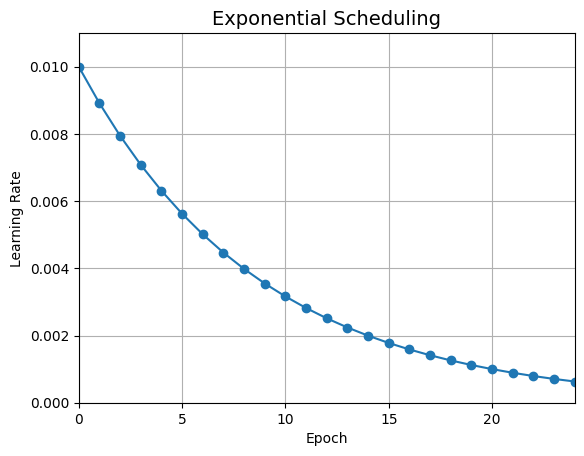

In [28]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

También se puede modificar la función de decaemiento exponencial al añadir un valor en particular para la razón de aprendizaje.

In [29]:
def exponential_decay_fn(epoch, lr):
  return lr * 0.1**(1 / 20)

Otra forma útil de actualizar la razón de aprendizaje es si la mejor pérdida en el conjunto de validación no mejora por $x$ epochs consecutivas (la paciencia).

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

In [31]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
  keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
  keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5561 - accuracy: 0.8011 - val_loss: 0.4833 - val_accuracy: 0.8382 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4381 - accuracy: 0.8430 - val_loss: 0.4572 - val_accuracy: 0.8408 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4151 - accuracy: 0.8492 - val_loss: 0.3776 - val_accuracy: 0.8616 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3928 - accuracy: 0.8595 - val_loss: 0.4104 - val_accuracy: 0.8590 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3765 - accuracy: 0.8646 - val_loss: 0.3783 - val_accuracy: 0.8608 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3729 - accuracy: 0.8661 - val_loss: 0.3837 - val_accuracy: 0.8714 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 8s

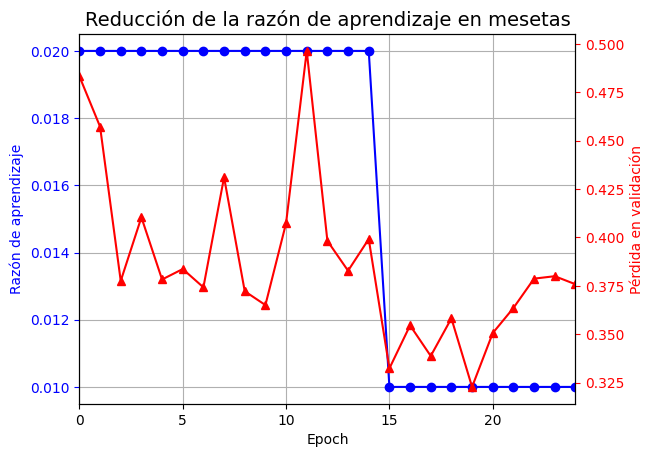

In [32]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Razón de aprendizaje", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Pérdida en validación', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reducción de la razón de aprendizaje en mesetas", fontsize=14)
plt.show()

## Optimizadores más rápidos

Entrenar una red neuronal puede ser muy lento, especialmente si es muy profunda. Un componente importante es utilizar buenos parámetros iniciales y funciones no saturantes, pero otro punto que podemos mejorar es el algoritmo usado para optimizar los pesos de la red. Hasta el momento usamos gradiente descendiente, pero vamos a explorar algunas alternativas.

### Momentum Optimization

Gradiente descendiente toma pequeños pasos de forma regular para ir colina abajo. Es decir, gradiente descendiente actualiza los pesos $\theta$ restando el gradiente de la función de costo $J(\theta)$ respecto a los pesos ($\nabla_{\theta}J(\theta)$) multiplicado por la razón de aprendizaje $\eta$. Esta idea no considera el valor de los gradientes anteriores, por lo que si adopta un valor puqueño, el algoritma tarda en llegar a un óptimo.

Momentum optimization considera los valores previos del gradiente. En cada iteración, resta el valor local del gradiente del vector de momento $m$ y actualiza los pesos añdiendo este vector de momento. Imaginen una bola de billar rodando hacia abajo en una superficie suave: empieza lento, pero adquiere momento rápidamente hasta que llegar a una velocidad terminal (asumiendo que existe cierta fricción entre la bola y la superficie). Lo último se puede simular agregando una variable $\beta$ al vector de momento.

$$\begin{align}
  m ←& \beta m-\eta \nabla_{\theta}J(\theta)\\
  \theta ← & \theta + m
\end{align}
$$

Implementarlo en Keras es tan sencillo como hacer lo siguiente:

In [33]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

Una variación de optimización por momento, Nesterov Accelerated Gradient (NAG) determina el gradiente de la función de costo no en el punto local $\theta$, sino un poco más adelante en la dirección del momento:

$$\begin{align}
  m ←& \beta m-\eta \nabla_{\theta}J(\theta + \beta m)\\
  \theta ← & \theta + m
\end{align}
$$

La idea es que este ajuste ocasiona que el gradiente apunte (recuerden que es un vector) en dirección del óptimo, lo que lo vuelve más preciso y rápido, en general.

In [34]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

La idea de AdaGrad es modificar la trayectoria del gradiente para que, en cada paso, se oriente hacia el óptimo, lo cual acelera la congergencia del algoritmo. Esto se logra escalando el vector del gradiente en su dimensión más empinada:

$$
\begin{align}
  s ←& s + \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)\\
  \theta ← & \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s+\epsilon}
\end{align}
$$

El primer caso acumula el cuadrado de los gradiente en el vector $s$ ($\otimes$ indica una multiplicación entrada por entrada). Lo anterior es equivalente e calcular $s_i + (\frac{∂J(\theta)}{∂\theta_i})^2$ para cada elemento $s_i$ del vector $s$. Si la función de costo es más empinanda en la $i$-ésima dimensión, $s_i$ se vuelve más grande con cada iteración.

El segundo paso es casi idéntico a gradiente descendiente, salvo el detalle que el vector de gradiente ($\nabla_{\theta}J(\theta)$) se escala por un factor de $\sqrt{s + \epsilon}$ (el símbolo $⊘$ indica división entrada por entrada), donde $\epsilon$ es término de suavizado y evitar divisiones por cero (usualmente $10^{-10}$).

Al juntar ambos componentes, el algoritmo provoca un decaemiento en la razón de aprendizaje, pero acelera el proceso en las dimensiones más empinadas que en las más suaves. A pesar de su poder, tiene el problema de que los cambios en la razón de aprendizaje provocan que el algoritmo se detenga por completo antes de encontrar el óptimo, por lo que no se usa tanto como esperaríamos.

### RMSProp

El algoritmo RMSProp soluciona el problema de AdaGrad acumulando solo los gradientes de las iteraciones más reciente, en lugar de todos desde que inica el entrenamiento) de la siguiente manera:

$$
\begin{align}
  s ←& \beta s + (1-\beta)\nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)\\
  \theta ← & \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s+\epsilon}
\end{align}
$$

Es decir, introduce una variable de decaemiento $\beta$ cuyo valor suele ser 0.9.

In [35]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam

Adaptative Momento Estimation (Adam), combina las ideas de optimización por momento y RMSProp: al igual que optimización por momento, mantiene la información de los gradiente anteriores, y de RMSProp mantiene la información del cuadrado de los gradiente anteriores (todo consireando un decaemiento exponencial):

$$\begin{align}
  m ←& \beta_1 m-(1-\beta_1) \nabla_{\theta}J(\theta)\\
  s ←& \beta_2 s + (1-\beta_2)\nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)\\
  \hat{m} ←& \frac{m}{1-\beta_1^t}\\
  \hat{s} ←& \frac{s}{1-\beta_2^t}\\
  \theta ← & \theta + \eta \hat{m} ⊘ \sqrt{\hat{s}+\epsilon}
\end{align}
$$

donde $t$ representa la iteración en turno.

In [36]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Noten que Adam (y Nadam) son los métodos que se usan comúnmente para llevar a cabo el proceso de optimización de los parámetros. Además, existen otras familias de optimizadores (los anteriores se basan en parciales de primer orden, o Jacobianos), como aquellos basados en Hessianos y metaheurísticas.

## Regularización en redes neuronales

### Dropout

Esta técnica es una de las más utilizadas para regularizar redes neuronales dada su simpleza y gran efectividad. Propuesta por Hinton en 2012, en cada paso de entrenamiento, cada neurona (excluyendo las de salida) tienen una probabilidad $p$ de ser temporalmente abandonadas, es decir, se ignoran en ese paso del entrenamiento de la red, pero es posible que en el siguiente no lo sean. El hiperparámetro $p$ se conoce lo como *dropout rate* y suele adoptar valores entre 10% y 50%.

In [37]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(10, activation="softmax")
])

In [40]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5832 - accuracy: 0.7890 - val_loss: 0.4149 - val_accuracy: 0.8464
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4640 - accuracy: 0.8269 - val_loss: 0.3823 - val_accuracy: 0.8580


Si utilizan como función de activación la SELU, deben usar una técnica llamada alpha dropout, ya que dropout rompe la idea de normalización de las entradas que introduce la función.

Otras técnicas de regularización incluyen Monte Carlo Dropout, regularización $l_1$ y $l_2$; y regularización Max-Norm.

## Ejercicios

Para esta práctica, van a crear y entrenar una red neuronal con el conjunto de datos Fashion MNIST, una variación del MNIST que, en lugar de números, busca clasificar piezas de ropa en 10 distintas categorías.

1. Describan brevemente las características del conjunto de datos Fashion MNIST.
2. Importen los datos (se encuentra disponible en Keras), usen min-max normalization para que los datos de cada pixel se encuentren entre 0 y 1, y crean las particiones de entrenamiento, prueba y validación.
3. Crear una red neuronal con las siguientes características:
 - 2 capas ocultas de 300 neuronas cada una.
 - Inicialización de pesos usando el método de He con distribución normal.
 - Función de activación `elu`.
 - Dropout en cada capa del 20% como medida de regularización del modelo.
 - `adam` como método de optimización.
 - Crear y utilizar un actualizador de razón de aprendizaje (usen *exponential scheduling*).
 - 100 epochs con early stopping del 10% (del número de epochs).
 - Para la métrica de evaluación del modelo, usen accuracy.
4. Reportar la gráfica de pérdida y accuracy contra epochs, además de su métrica de accuracy en el conjunto de entrenamiento.

Ojo: recuerden que función de activación usar en la capa de salida y la pérdida para este problema de clasificación.